# **NODEO-DIR**
A Neural Ordinary Differential Equation Based Optimization Framework for Deformable Image Registration.

**Reproducibility Project Goals:**
- reproduce table 1
- reproduce figure 4 (map 3D to 2D)


## Setup

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deep Learning/Reproducibility Project')

Mounted at /content/drive


In [2]:
!pip install nibabel --upgrade
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4


## Loss

In [3]:
import torch
import torch.nn.functional as F

class NCC(torch.nn.Module):
    """
    NCC with cumulative sum implementation for acceleration. local (over window) normalized cross correlation.
    """

    def __init__(self, win=21, eps=1e-5):
        super(NCC, self).__init__()
        self.eps = eps
        self.win = win
        self.win_raw = win

    def window_sum_cs2D(self, I, win_size):
        half_win = int(win_size / 2)
        pad = [half_win + 1, half_win] * 2

        I_padded = F.pad(I, pad=pad, mode='constant', value=0)  # [x+pad, y+pad]

        # Run the cumulative sum across all 2 dimensions
        I_cs_x = torch.cumsum(I_padded, dim=2)
        I_cs_xy = torch.cumsum(I_cs_x, dim=3)

        x, y = I.shape[2:]

        # Use subtraction to calculate the window sum
        I_win = I_cs_xy[:, :, win_size:, win_size:] \
            - I_cs_xy[:, :, win_size:, :y] \
            - I_cs_xy[:, :, :x, win_size:] \
            + I_cs_xy[:, :, :x, :y]

        return I_win

    def forward(self, I, J):
        # compute CC squares
        I = I.double()
        J = J.double()

        I2 = I * I
        J2 = J * J
        IJ = I * J

        # compute local sums via cumsum trick
        I_sum_cs = self.window_sum_cs2D(I, self.win)
        J_sum_cs = self.window_sum_cs2D(J, self.win)
        I2_sum_cs = self.window_sum_cs2D(I2, self.win)
        J2_sum_cs = self.window_sum_cs2D(J2, self.win)
        IJ_sum_cs = self.window_sum_cs2D(IJ, self.win)

        win_size_cs = (self.win * 1.) ** 2

        u_I_cs = I_sum_cs / win_size_cs
        u_J_cs = J_sum_cs / win_size_cs

        cross_cs = IJ_sum_cs - u_J_cs * I_sum_cs - u_I_cs * J_sum_cs + u_I_cs * u_J_cs * win_size_cs
        I_var_cs = I2_sum_cs - 2 * u_I_cs * I_sum_cs + u_I_cs * u_I_cs * win_size_cs
        J_var_cs = J2_sum_cs - 2 * u_J_cs * J_sum_cs + u_J_cs * u_J_cs * win_size_cs

        cc_cs = cross_cs * cross_cs / (I_var_cs * J_var_cs + self.eps)
        cc2 = cc_cs  # cross correlation squared

        # return negative cc.
        return 1. - torch.mean(cc2).float()

def JacboianDet(J):
    if J.size(-1) != 2:
        J = J.permute(0, 2, 3, 1)
    J = J + 1
    J = J / 2.
    scale_factor = torch.tensor([J.size(1), J.size(2)]).to(J).view(1, 1, 1, 2) * 1.
    J = J * scale_factor

    dy = J[:, 1:, :-1, :] - J[:, :-1, :-1, :]
    dx = J[:, :-1, 1:, :] - J[:, :-1, :-1, :]

    Jdet = dx[:, :, :, 0] * dy[:, :, :, 1] - dx[:, :, :, 1] * dy[:, :, :, 0]
    return Jdet

def neg_Jdet_loss(J):
    Jdet = JacboianDet(J)
    neg_Jdet = -1.0 * (Jdet - 0.5)
    selected_neg_Jdet = F.relu(neg_Jdet)
    return torch.mean(selected_neg_Jdet ** 2)

def smoothloss_loss(df):
    return (((df[:, :, 1:, :] - df[:, :, :-1, :]) ** 2).mean() + \
                ((df[:, :, :, 1:] - df[:, :, :, :-1]) ** 2).mean())

def magnitude_loss(all_v):
    all_v_x_2 = all_v[:, :, 0, :, :] * all_v[:, :, 0, :, :]
    all_v_y_2 = all_v[:, :, 1, :, :] * all_v[:, :, 1, :, :]
    all_v_magnitude = torch.mean(all_v_x_2 + all_v_y_2)
    return all_v_magnitude

## Neural ODE

In [4]:
import numpy as np
import torch
from torch import Tensor
from torch import nn

def RK(z0, n_steps, f, h):
    '''
    4th Order Runge Kutta Numerical Solver
    Input:
      z0: initial condition
      t0: initial time (not actual time, but the index of time)
      n_steps: the number of steps to integrate
      f: vector field
      h: step size
    Return:
      z: the state after n_steps
    '''
    z = z0
    for i in range(int(n_steps)):
        k1 = h * f(z)
        k2 = h * f(z + 0.5 * k1)
        k3 = h * f(z + 0.5 * k2)
        k4 = h * f(z + k3)
        z = z + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return z

def Euler(z0, n_steps, f, step_size):
    '''
    Simplest Euler ODE initial value solver
    Input:
      z0: initial condition
      t0: initial time (not actual time, but the index of time)
      n_steps: the number of steps to integrate
      f: input phi -> output vector field
      h: step size
    Return:
      z: the state after n_steps
    '''
    z = z0
    for i_step in range(int(n_steps)):
        z = z + step_size * f(z)
    return z

class ODEF(nn.Module):
    def forward_with_grad(self, z, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]
        out = self.forward(z)

        a = grad_outputs
        adfdz, *adfdp = torch.autograd.grad(
            # concatenating tuples
            (out,), (z,) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(
                0)  # unsqueeze(0) add dimension 1 to the position 0
            adfdp = adfdp.expand(batch_size, -1) / batch_size  # passing -1 does not change dimension in that position
        return out, adfdz, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)


class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func, ode_solve, STEP_SIZE):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            # initialize z to len of time and type of z0
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            # solving throughout time
            for i_t in range(time_len - 1):
                # z0 updated to next step
                z0 = ode_solve(z0, torch.abs(t[i_t + 1] - t[i_t]), func, STEP_SIZE)
                z[i_t + 1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        ctx.ode_solve = ode_solve
        ctx.STEP_SIZE = STEP_SIZE
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)
        ode_solve = ctx.ode_solve
        STEP_SIZE = ctx.STEP_SIZE

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2 * n_dim]  # ignore parameters and time
            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)

            with torch.set_grad_enabled(True):
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdp = func.forward_with_grad(z_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience

        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            # adj_t = torch.zeros(time_len, bs, 1).to(dLdz)
            for i_t in range(time_len - 1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                # f_i = func(z_i).view(bs, n_dim)
                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z)), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, torch.abs(t_i - t[i_t - 1]), augmented_dynamics, -STEP_SIZE)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2 * n_dim]
                adj_p[:] += aug_ans[:, 2 * n_dim:2 * n_dim + n_params]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]

            # Adjust adjoints
            adj_z += dLdz_0
        return adj_z.view(bs, *z_shape), None, adj_p, None, None, None


class NeuralODE(nn.Module):
    def __init__(self, func, ode_solve, STEP_SIZE):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func
        self.ode_solve = Euler if ode_solve == 'Euler' else RK
        self.STEP_SIZE = STEP_SIZE

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func, self.ode_solve, self.STEP_SIZE)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

## Network

In [16]:
import math
import numpy as np
import scipy.stats as st
import torch
import torch.nn.functional as F
from torch import nn

#from NeuralODE import ODEF


class GaussianKernel(torch.nn.Module):
    def __init__(self, win=11, nsig=0.1):
        super(GaussianKernel, self).__init__()
        self.win = win
        self.nsig = nsig
        kernel_x, kernel_y = self.gkern1D_xy(self.win, self.nsig)
        kernel = kernel_x * kernel_y
        self.register_buffer("kernel_x", kernel_x)
        self.register_buffer("kernel_y", kernel_y)
        self.register_buffer("kernel", kernel)

    def gkern1D(self, kernlen=None, nsig=None):
        '''
        :param nsig: large nsig gives more freedom(pixels as agents), small nsig is more fluid.
        :return: Returns a 1D Gaussian kernel.
        '''
        x = np.linspace(-nsig, nsig, kernlen + 1)
        kern1d = np.diff(st.norm.cdf(x))
        kern1d = kern1d / kern1d.sum()
        return torch.tensor(kern1d, requires_grad=False).float()

    def gkern1D_xy(self, kernlen=None, nsig=None):
        """Returns 2 1D Gaussian kernel on xy direction."""
        kernel_1d = self.gkern1D(kernlen, nsig)
        kernel_x = kernel_1d.view(1, 1, -1, 1)
        kernel_y = kernel_1d.view(1, 1, 1, -1)
        return kernel_x, kernel_y

    def forward(self, x):
        pad = int((self.win - 1) / 2)
        # Apply Gaussian by 2D kernel
        x = F.conv2d(x, self.kernel, padding=pad)
        return x


class AveragingKernel(torch.nn.Module):
    def __init__(self, win=11):
        super(AveragingKernel, self).__init__()
        self.win = win

    def window_averaging(self, v):
        win_size = self.win
        v = v.double()

        half_win = int(win_size / 2)
        pad = [half_win + 1, half_win] * 2

        v_padded = F.pad(v, pad=pad, mode='constant', value=0)  # [x+pad, y+pad]

        # Run the cumulative sum across all 2 dimensions
        v_cs_x = torch.cumsum(v_padded, dim=2)
        v_cs_xy = torch.cumsum(v_cs_x, dim=3)

        x, y = v.shape[2:]

        # Use subtraction to calculate the window sum
        v_win = v_cs_xy[:, :, win_size:, win_size:] \
                - v_cs_xy[:, :, win_size:, :y] \
                - v_cs_xy[:, :, :x, win_size:] \
                + v_cs_xy[:, :, :x, :y]

        # Normalize by number of elements
        v_win = v_win / (win_size ** 2)
        v_win = v_win.float()
        return v_win

    def forward(self, v):
        return self.window_averaging(v)


class BrainNet(ODEF):
    def __init__(self, img_sz, smoothing_kernel, smoothing_win, smoothing_pass, ds, bs):
        super(BrainNet, self).__init__()
        padding_mode = 'replicate'
        bias = True
        self.ds = ds
        self.bs = bs
        self.img_sz = img_sz
        self.smoothing_kernel = smoothing_kernel
        self.smoothing_pass = smoothing_pass
        
        # Define convolutional layers
        self.enc_conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode, bias=bias)
        self.enc_conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode, bias=bias)
        self.enc_conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode, bias=bias)
        self.enc_conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode, bias=bias)
        self.enc_conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, padding_mode=padding_mode, bias=bias)
        self.bottleneck_sz = int(
            math.ceil(img_sz[0] / pow(2, self.ds)) * math.ceil(img_sz[1] / pow(2, self.ds)))
        
        # Activation function
        self.relu = nn.ReLU()

        # Calculate the number of in-features for the linear layer dynamically based on input size
        self.in_features = self.calculate_in_features()

        # Linear layers
        self.lin1 = nn.Linear(self.in_features, self.bs, bias=bias)
        self.lin2 = nn.Linear(self.bs, self.bottleneck_sz * 2, bias=bias)

        # Create smoothing kernels
        if self.smoothing_kernel == 'AK': # Averaging Kernel
            self.sk = AveragingKernel(win=smoothing_win)
        else: # Gaussian Kernel
            self.sk = GaussianKernel(win=smoothing_win, nsig=0.1)
    
    def calculate_in_features(self):
        """
        Calculates the number of in-features for the linear layer dynamically based on input size.
        """
        x = torch.randn(1, 2, self.img_sz[0], self.img_sz[1])  # Create a dummy input tensor
        x = F.interpolate(x, scale_factor=0.5, mode='bilinear')  # Optional to downsample the image
        x = self.relu(self.enc_conv1(x))
        x = self.relu(self.enc_conv2(x))
        x = self.relu(self.enc_conv3(x))
        x = self.relu(self.enc_conv4(x))
        x = self.enc_conv5(x)
        return x.view(x.size(0), -1).size(1)  # Flatten the tensor and return the number of features

    def forward(self, x):
        # Image dimensions
        imgx = self.img_sz[0]
        imgy = self.img_sz[1]

        # Optional to downsample the image
        x = F.interpolate(x, scale_factor=0.5, mode='bilinear')

        # Convolutional layers
        x = self.relu(self.enc_conv1(x))
        x = self.relu(self.enc_conv2(x))
        x = self.relu(self.enc_conv3(x))
        x = self.relu(self.enc_conv4(x))
        x = self.enc_conv5(x)

        # Flatten tensor and apply linear layers
        x = x.view(-1)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)

        # Reshape
        x = x.view(1, 2, int(math.ceil(imgx / pow(2, self.ds))), int(math.ceil(imgy / pow(2, self.ds))))
        
        # Upsampling
        for _ in range(self.ds):
            x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # Apply smoothing
        #for _ in range(self.smoothing_pass):
        #    if self.smoothing_kernel == 'AK': # Averaging Kernel
        #        x = self.sk(x)
        #    else: # Gaussian Kernel
        #        x_x = self.sk(x[:, 0, :, :].unsqueeze(1))
        #        x_y = self.sk(x[:, 1, :, :].unsqueeze(1))
        #        x = torch.cat([x_x, x_y], 1)
        return x

## Utils

In [17]:
import numpy as np
import nibabel as nib
#from Loss import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow, return_phi=False):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # grid_sample function of PyTorch expects the spatial dimensions to be in the last dimensions of the tensor
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1) # pytorch grid_sample expects (batch, height, width, dim)
            new_locs = new_locs[..., [1, 0]] # pytorch expects (y, x)
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1) # pytorch grid_sample expects (batch, depth, height, width, dim)
            new_locs = new_locs[..., [2, 1, 0]] # pytorch expects (z, y, x)

        if return_phi:
            return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode), new_locs
        else:
            return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

def load_nii(path):
    """
    Load a NIfTI file from disk and extract the data array and affine transformation matrix
    """
    X = nib.load(path)
    affine = X.affine
    X = X.get_fdata()
    X = X[:,:,0]
    return X, affine

def save_nii(img, savename, affine):
    """
    Save a NIfTI file to disk
    """
    new_img = nib.nifti1.Nifti1Image(img, affine, header=None)
    nib.save(new_img, savename)

def generate_grid2D_tensor(shape):
    """
    Generate a 2D grid tensor of the specified shape.
    """
    x_grid = torch.linspace(-1., 1., shape[0])
    y_grid = torch.linspace(-1., 1., shape[1])
    x_grid, y_grid = torch.meshgrid(x_grid, y_grid)

    # Note that default the dimension in the grid is reversed:
    # y, x
    grid = torch.stack([y_grid, x_grid], dim=0)
    return grid

def dice(array1, array2, labels):
    """
    Computes the dice overlap between two arrays for a given set of integer labels.
    """
    dicem = np.zeros(len(labels))
    for idx, label in enumerate(labels):
        top = 2 * np.sum(np.logical_and(array1 == label, array2 == label))
        bottom = np.sum(array1 == label) + np.sum(array2 == label)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon
        dicem[idx] = top / bottom
    return dicem

## Registration

In [21]:
import argparse
import os
import time
import types
#from Network import BrainNet
#from Loss import *
#from NeuralODE import *
#from Utils import *

def main(config, dice_list):
    # Specify device and load images and their affine transformation matrices
    device = torch.device(config.device)
    fixed, affine_fixed = load_nii(config.fixed)
    moving, affine_moving = load_nii(config.moving)

    # Check that the fixed and moving images have the same size and affine transformation matrix
    assert fixed.shape == moving.shape
    assert (affine_fixed == affine_moving).all()
    config.affine = affine_fixed

    # Registration
    print('---Registration---')
    t = time.time()
    df, df_with_grid, warped_moving = registration(config, device, moving, fixed)
    runtime = time.time() - t
    print('Registration Running Time:', runtime)
    print('---Registration DONE---')
    print()


    # Evaluate registration results and update the list of dice scores
    print('---Evaluation---')
    dice_list, neg_Jet = evaluation(config, device, df, df_with_grid, dice_list)
    print('---Evaluation DONE---')
    print()

    # Save results
    save_result(config, df, warped_moving, neg_Jet, df_with_grid)
    print('---Results SAVED---')
    print()

    return dice_list

def registration(config, device, moving, fixed):
    '''
    Registration moving to fixed.
    :param config: configurations.
    :param device: gpu or cpu.
    :param moving: moving image to be registered, geodesic shooting starting point.
    :param fixed: fixed image, geodesic shooting target.
    :return best_df: displacement field at the end of training, without grid.
    :return best_df_with_grid: displacement field at the end of training, with grid.
    :return best_warped_moving: warped moving image at the end of training.
    '''
    # Image Shape (fixed.shape == moving.shape)
    im_shape = fixed.shape

    # Convert moving and fixed images to PyTorch tensors and move to specified device
    moving = torch.from_numpy(moving).to(device).float()
    fixed = torch.from_numpy(fixed).to(device).float()
    
    # Make batch dimension
    moving = moving.unsqueeze(0).unsqueeze(0)
    fixed = fixed.unsqueeze(0).unsqueeze(0)

    # Initialize neural network
    Network = BrainNet(img_sz=im_shape,
                       smoothing_kernel=config.smoothing_kernel,
                       smoothing_win=config.smoothing_win,
                       smoothing_pass=config.smoothing_pass,
                       ds=config.ds,
                       bs=config.bs
                       ).to(device)
    # Initialize NeuralODE for solving the ODE
    ode_train = NeuralODE(Network, config.optimizer, config.STEP_SIZE).to(device)

     # Define scale factor, spatial transformer and grid
    scale_factor = torch.tensor(im_shape).to(device).view(1, 2, 1, 1) * 1.
    ST = SpatialTransformer(im_shape).to(device)  # spatial transformer to warp image
    grid = generate_grid2D_tensor(im_shape).unsqueeze(0).to(device)  # [-1,1]

    # Define optimizer
    optimizer = torch.optim.Adam(ode_train.parameters(), lr=config.lr, amsgrad=True)
    
    # Initialize loss functions, df, df_with_grid, and warped_moving
    # Similarity loss
    loss_NCC = NCC(win=config.NCC_win)

    BEST_loss_sim_loss_J = 1000
    best_df = None
    best_df_with_grid = None
    best_warped_moving = None

    # Training loop
    for i in range(config.epoches):
        # Compute displacement and velocity field
        all_phi = ode_train(grid, Tensor(np.arange(config.time_steps)), return_whole_sequence=True)
        all_v = all_phi[1:] - all_phi[:-1]

        # Convert displacement field to voxel spacing and warp moving image using the spatial transformer
        all_phi = (all_phi + 1.) / 2. * scale_factor  # [-1, 1] -> voxel spacing
        phi = all_phi[-1]
        grid_voxel = (grid + 1.) / 2. * scale_factor  # [-1, 1] -> voxel spacing
        df = phi - grid_voxel  # with grid -> without grid
        warped_moving, df_with_grid = ST(moving, df, return_phi=True)
        
        # Similarity loss
        loss_sim = loss_NCC(warped_moving, fixed)

        # Squeeze batch and channel dimensions from warped moving image
        warped_moving = warped_moving.squeeze(0).squeeze(0)

        # V magnitude loss
        loss_v = config.lambda_v * magnitude_loss(all_v)

        # Neg Jacobian loss
        loss_J = config.lambda_J * neg_Jdet_loss(df_with_grid)

        # Phi dphi/dx loss
        loss_df = config.lambda_df * smoothloss_loss(df)

        # Total Loss
        #loss = loss_sim + loss_v + loss_J + loss_df
        loss = loss_sim + loss_v + loss_df
        # loss = loss_sim  + loss_J

        optimizer.zero_grad() # Zero out gradients from previous iteration
        loss.backward() # Backpropagate the loss
        optimizer.step() # Update the weights

        # Print loss information every 20 epochs
        if (i + 1) % 20 == 0:
            print("Iteration: {0} Loss_sim: {1:.3e} loss_J: {2:.3e}".format(i + 1, loss_sim.item(), loss_J.item()))
        # Pick the one df with the most balance loss_sim and loss_J in the last 50 epoches
        if i > config.epoches - 50:
            loss_sim_loss_J = 1000 * loss_sim.item() * loss_J.item() # Product of loss_sim and loss_J, scaled by 1000
            if loss_sim_loss_J < BEST_loss_sim_loss_J: # If less than the current best loss, update values
                best_df = df.detach().clone()
                best_df_with_grid = df_with_grid.detach().clone()
                best_warped_moving = warped_moving.detach().clone()
    return best_df, best_df_with_grid, best_warped_moving


def evaluation(config, device, df, df_with_grid, dice_list):
    """
    Evaluation of registration by calculating negative Jacobian ratio and dice score.
    :param config: configuration parameters
    :param device: device to run the model on
    :param df: displacement field without grid
    :param df_with_grid: displacement field with grid
    :param dice_list: list of dice scores
    :return dice_res: mean dice score on given structures
    :return neg_Jet: negative jacobian
    """
    ### Calculate Neg Jac Ratio
    neg_Jet = -1.0 * JacboianDet(df_with_grid)
    neg_Jet = F.relu(neg_Jet)
    mean_neg_J = torch.sum(neg_Jet).detach().cpu().numpy()
    num_neg = len(torch.where(neg_Jet > 0)[0])
    total = neg_Jet.size(-1) * neg_Jet.size(-2)
    ratio_neg_J = num_neg / total
    print('Total of neg Jet: ', mean_neg_J)
    print('Ratio of neg Jet: ', ratio_neg_J)

    ### Calculate Dice
    # Define the list of labels for structures to be evaluated
    label = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    
    fixed_seg, _ = load_nii(config.fixed_seg)
    moving_seg, _ = load_nii(config.moving_seg)
    ST_seg = SpatialTransformer(fixed_seg.shape, mode='nearest').to(device)
    moving_seg = torch.from_numpy(moving_seg).to(device).float()
    # Make batch dimension
    moving_seg = moving_seg[None, None, ...]
    warped_seg = ST_seg(moving_seg, df, return_phi=False)
    dice_move2fix = dice(warped_seg.unsqueeze(0).unsqueeze(0).detach().cpu().numpy(), fixed_seg, label)
    dice_res = np.mean(dice_move2fix[0])
    print('Avg. dice on %d structures: ' % len(label), dice_res)

    return dice_res, neg_Jet

def save_result(config, df, warped_moving, neg_Jet, df_with_grid):
    """
    Save the displacement field and the warped moving image to disk.
    """
    # Save neg Jet as a numpy array
    np.save('%s_neg_Jet.npy' % (config.savepath), neg_Jet.cpu().detach().numpy())

    # Save df with grid as numpy array
    np.save('%s_df_with_grid.npy' % (config.savepath), df_with_grid.cpu().detach().numpy())

    save_nii(df.permute(2,3,0,1).detach().cpu().numpy(), '%s_df.nii.gz' % (config.savepath), config.affine)
    save_nii(warped_moving.detach().cpu().numpy(), '%s_warped.nii.gz' % (config.savepath), config.affine)

def createConfig(id_fixed, id_moving):
    """
    Configuration
    """
    # Create Config
    config = types.SimpleNamespace()

    config.id_fixed = id_fixed # ID of fixed image
    config.id_moving = id_moving # ID of moving image
    config.affine = None # affine transformation matrix (assigned later after image has been loaded)

    # File Paths
    config.fixed = 'data/2D/oasis/OASIS_OAS1_0' + id_fixed + '_MR1/slice_norm.nii.gz'
    config.moving = 'data/2D/oasis/OASIS_OAS1_0' + id_moving + '_MR1/slice_norm.nii.gz'
    config.fixed_seg = 'data/2D/oasis/OASIS_OAS1_0' + id_fixed + '_MR1/slice_seg24.nii.gz'
    config.moving_seg = 'data/2D/oasis/OASIS_OAS1_0' + id_moving +  '_MR1/slice_seg24.nii.gz'
    config.savepath = 'result2d/oasis/' + config.id_fixed + config.id_moving

    # Model Configuration
    config.ds = 2 # Downsampling factor
    config.bs = 16 # Batch Size
    config.smoothing_kernel = 'GK' # Smoothing kernel type ('AK' (Averaging Kernel) or 'GK' (Gaussian Kernel))
    config.smoothing_win = 15 # Smoothing window size
    config.smoothing_pass = 1 # Number of smoothing passes

    # Training Configuration
    config.time_steps = 2
    config.optimizer = 'Euler' # Solver type ('Euler' or 'RK' (4th Order Runge Kutta))
    config.STEP_SIZE = 0.001
    config.epoches = 300
    config.lr = 0.005
    config.loss_sim = 'NCC' # NCC (Normalized Cross Correlation)
    config.NCC_win = 21
    config.lambda_J = 2.5
    config.lambda_df = 0.05
    config.lambda_v = 0.00005

    # Debug
    config.debug = False
    config.device = 'cuda:0'

    return config

if __name__ == '__main__':
    # Assign Image IDs
    #fixed_ids = [1, 10, 20, 30, 40]
    #moving_ids = [2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49]
    
    # For running a single image pair, adjust code like in the following two lines
    fixed_ids = [1]
    moving_ids = [2]
    
    dice_list = [] # initialise list to store dice scores

    for id_fixed in fixed_ids:
      for id_moving in moving_ids:
        print("-----------------------")
        print("NEW SET")
        print("Fixed Image ID: " + str(id_fixed).zfill(3))
        print("Moving Image ID: " + str(id_moving).zfill(3))
        print("-----------------------")
        print()
        config = createConfig(str(id_fixed).zfill(3), str(id_moving).zfill(3))
        dice_list.append(main(config, dice_list))

    # Calculate mean dice score and standard deviation
    mean_dice_score = np.mean(dice_list)
    squared_diff = (dice_list - mean_dice_score) ** 2
    variance = np.mean(squared_diff)
    std_deviation = np.sqrt(variance)
    
    print("--------------")
    print("Dice Mean Scores Array: " + str(dice_list))
    print("Overall Mean Dice Score: " + str(mean_dice_score))
    print("Standard Deviation of Mean Dice Scores: " + str(std_deviation))
    print("--------------")

-----------------------
NEW SET
Fixed Image ID: 001
Moving Image ID: 002
-----------------------

---Registration---
Iteration: 20 Loss_sim: 6.206e-01 loss_J: 9.773e-01
Iteration: 40 Loss_sim: 4.502e-01 loss_J: 2.330e-01
Iteration: 60 Loss_sim: 4.096e-01 loss_J: 2.377e-01
Iteration: 80 Loss_sim: 3.957e-01 loss_J: 2.365e-01
Iteration: 100 Loss_sim: 3.905e-01 loss_J: 2.207e-01
Iteration: 120 Loss_sim: 3.865e-01 loss_J: 2.653e-01
Iteration: 140 Loss_sim: 3.849e-01 loss_J: 2.717e-01
Iteration: 160 Loss_sim: 3.838e-01 loss_J: 2.635e-01
Iteration: 180 Loss_sim: 3.834e-01 loss_J: 2.307e-01
Iteration: 200 Loss_sim: 3.870e-01 loss_J: 1.945e-01
Iteration: 220 Loss_sim: 3.850e-01 loss_J: 2.011e-01
Iteration: 240 Loss_sim: 3.807e-01 loss_J: 2.581e-01
Iteration: 260 Loss_sim: 3.804e-01 loss_J: 2.553e-01
Iteration: 280 Loss_sim: 3.833e-01 loss_J: 2.102e-01
Iteration: 300 Loss_sim: 3.822e-01 loss_J: 2.170e-01
Registration Running Time: 4.870092391967773
---Registration DONE---

---Evaluation---
Total

## Result Plots

-----------------------
RESULT PLOTS
Fixed Image ID: 001
Moving Image ID: 002
-----------------------

Moving image


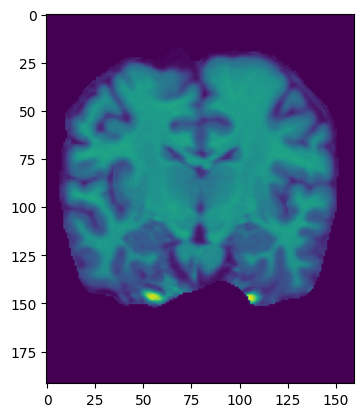

Warped image


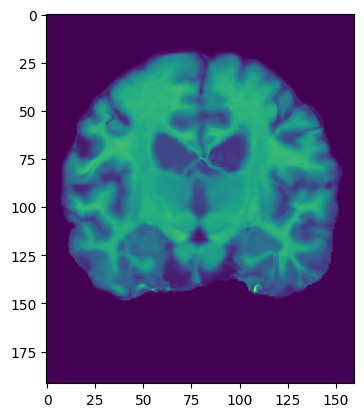

Fixed image


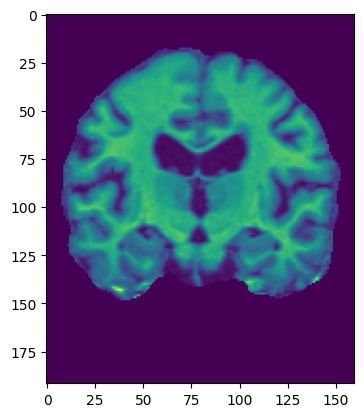

Deformation field with grid


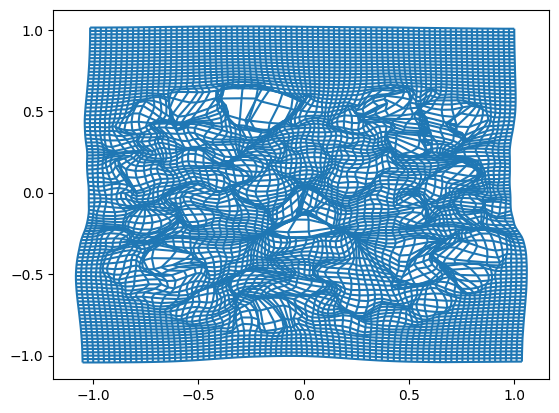

Deformation field


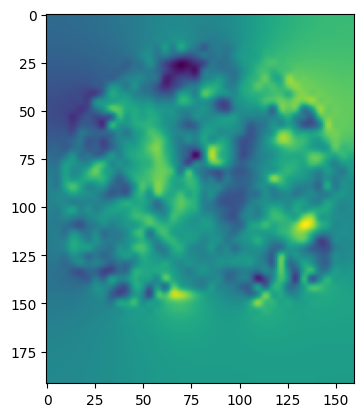

Neg Jet


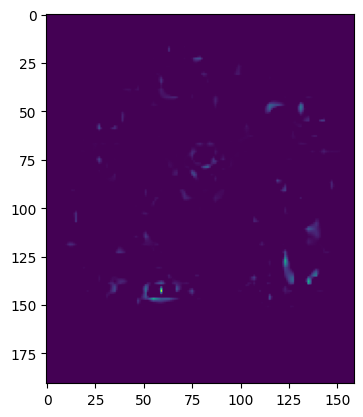

In [22]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib import image

def plot_df_with_grid(filepath):
    print("Deformation field with grid")
    df_with_grid = np.load(filepath)
    x = df_with_grid[0, :, :, 1]
    y = df_with_grid[0, :, :, 0]
    subsample = 2
    ax = plt.gca()
    segs1 = np.stack((x[::subsample, ::subsample], y[::subsample, ::subsample]), axis=2)
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1))
    ax.add_collection(LineCollection(segs2))
    ax.autoscale()
    plt.show()

def plot_nii(filepath):
    X = nib.load(filepath)    
    X = X.get_fdata()
    if len(X.shape) == 3:
      X = X[:, :, 0]
    elif len(X.shape) == 4:
      X = X[:, :, 0, 0]
    plt.imshow(X.transpose())
    plt.show()

def plot_neg_Jet(filepath):
    print("Neg Jet")
    neg_Jet = np.load(filepath)
    neg_Jet = neg_Jet[0,:, :]
    plt.imshow(neg_Jet.transpose())
    plt.show()

if __name__ == '__main__':
    # Choose fixed and moving image pair to visualise
    # The corresponding results have to be in results folder -> run registration first
    id_fixed = '001'
    id_moving = '002'

    print("-----------------------")
    print("RESULT PLOTS")
    print("Fixed Image ID: " + id_fixed)
    print("Moving Image ID: " + id_moving)
    print("-----------------------")
    print()

    # Moving Image -> Warped Moving Image -> Fixed Image
    print("Moving image")
    plot_nii('data/2D/oasis/OASIS_OAS1_0' + id_moving + '_MR1/slice_norm.nii.gz')
    print("Warped image")
    plot_nii('result2d/oasis/' + id_fixed + id_moving + '_warped.nii.gz')
    print("Fixed image")
    plot_nii('data/2D/oasis/OASIS_OAS1_0' + id_fixed + '_MR1/slice_norm.nii.gz')

    # Deformation field with grid
    plot_df_with_grid('result2d/oasis/' + id_fixed + id_moving + '_df_with_grid.npy')

    # Deformation Field
    print("Deformation field")
    plot_nii('result2d/oasis/' + id_fixed + id_moving + '_df.nii.gz')

    # Neg Jet
    plot_neg_Jet('result2d/oasis/' + id_fixed + id_moving + '_neg_Jet.npy')
    print()